In [ ]:
from datasets import load_dataset
import torch
import numpy as np
from transformers import AutoImageProcessor
from torchvision.transforms import ColorJitter
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer
import json
from huggingface_hub import cached_download, hf_hub_url

ds = load_dataset("scene_parse_150", split="train[:30]")
ds = ds.train_test_split(test_size=0.3)
train_ds = ds["train"]
test_ds = ds["test"]

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/home/arefhz75/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [ ]:
id2label = {k: str(k) for k in range(180)}
label2id = {str(k): k for k in range(180)}
num_labels = len(id2label)
feature_extractor = AutoImageProcessor.from_pretrained("nvidia/mit-b0", reduce_labels=True)


jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.7/dist-packages/transformers/models/segformer/image_processing_segformer.py:105: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  FutureWarning,


In [ ]:
import evaluate

metric = evaluate.load("mean_iou")
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = torch.nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [ ]:
pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(
    pretrained_model_name, id2label=id2label, label2id=label2id
)
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=5,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 40
  Num Epochs = 5
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 3760404


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
5,4.326700,4.458814,0.033553,0.155764,0.362521,"[0.061460412726476246, 0.4029415210378851, nan, nan, 0.4968699399205429, nan, 0.11505061170987474, nan, 0.0, 0.07397564555154496, nan, 0.3396507218039711, nan, 0.0, nan, 0.016004223157840523, 0.0, nan, 0.0, 0.004588477585820538, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.1696339607776499, 0.0, nan, 0.0, nan, nan, nan, nan, nan, 0.0, 0.01838880450651055, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, 0.08751027308803155, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.1364050906842539, nan, nan, nan, nan, 0.0, nan, 0.12423662038087077, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0]","[0.08031398896239673, 0.5239802534030318, nan, nan, 0.9638149425879203, nan, 0.45601818444219944, nan, nan, 0.13050536716442976, nan, 0.5624352023386644, nan, 0.0, nan, 0.0160391235902862, nan, nan, 0.0, 0.004677014107179761, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.38983607430351547, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.019062031856675533, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.5884544937788164, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.3547228717096668, nan, nan, nan, nan, nan, nan, 0.5830672186083186, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]"
10,4.504800,4.321340,0.037504,0.151333,0.307832,"[0.056692254584176836, 0.30058864599383667, nan, nan, 0.4940217078430765, nan, 0.12503347159149902, nan, nan, 0.06836772681081407, nan, 0.18313589153961005, nan, 0.0, nan, 0.040300848135701714, nan, nan, 0.009223300970873786, 0.0, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.1640004164208627, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, 0.01181841199862975, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, 0.07471920880131866, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, 0.09585602858512353, nan, nan, nan, nan, 0.0, nan, 0.1389277518179556, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0]","[0.06642786137867206, 0.3484681269224731, nan, nan, 0.957370029006402, nan, 0.41275797373358347, nan, nan, 0.09509747666298127, nan, 0.8568077910158574, nan, 0.0, nan, 0.04062040310717696, nan, nan, 0.009223300970873786, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.3355551019321399, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.01212968907640099, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.6155498010484431, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Trainer is attempting to log a value of "[0.061460412726476246, 0.4029415210378851, nan, nan, 0.4968699399205429, nan, 0.11505061170987474, nan, 0.0, 0.07397564555154496, nan, 0.3396507218039711, nan, 0.0, nan, 0.016004223157840523, 0.0, nan, 0.0, 0.004588477585820538, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.1696339607776499, 0.0, nan, 0.0, nan, nan, nan, nan, nan, 0.0, 0.01838880450651055, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, 0.08751027308803155, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.1364050906842539, nan, nan, nan, nan, 0.0, nan, 0.12423662038087077, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0,

Trainer is attempting to log a value of "[0.08782093031227504, 0.5383506125747911, nan, nan, 0.9661491855894822, nan, 0.3711213739356328, nan, nan, 0.16332414314304508, nan, 0.8400326325271513, nan, 0.0, nan, 0.07498258019561795, nan, nan, 0.13883495145631067, 0.004051599430056885, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.5134681778243235, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0341037634901709, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.5024000505273796, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.259253800338999, nan, nan, nan, nan, nan, nan, 0.4874630396215257, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan

Trainer is attempting to log a value of "[0.07164844205258286, 0.6485175515615279, nan, nan, 0.9919374216912964, nan, 0.7347560975609756, nan, nan, 0.23247449372314669, nan, 0.6625762700341622, nan, 0.0, nan, 0.18572737360964153, nan, nan, 0.048058252427184464, 0.002061149240257127, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.45174087847132854, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.07757803662600507, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.5156634876523716, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.13298004193939555, nan, nan, nan, nan, nan, nan, 0.5484525921545437, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0

Trainer is attempting to log a value of "[0.06286292119425496, 0.5964042121421802, nan, nan, 0.9925295642174279, nan, 0.8164237263674412, nan, nan, 0.30271647096692933, nan, 0.7653942247225385, nan, 0.0, nan, 0.18763064853286537, nan, nan, 0.08155339805825243, 0.011328163238669118, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.46870146352719816, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.04981044972331774, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.5500536853407441, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.11572861325311698, nan, nan, nan, nan, nan, nan, 0.5023654642223536, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

Trainer is attempting to log a value of "[0.05878380694477771, 0.6699469121229917, nan, nan, 0.9901652850007724, nan, 0.7367585510174628, nan, nan, 0.3314066589226485, nan, 0.7386168567398066, nan, 0.0, nan, 0.2990270716663656, nan, nan, 0.018932038834951457, 0.003681789012279881, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.4376026199710667, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.05356323947537375, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.48092591422977327, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.1374821623577176, nan, nan, nan, nan, nan, nan, 0.5739010447466982, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, n

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-80
Configuration saved in segformer-b0-scene-parse-150/checkpoint-80/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-80/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-20] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/arefhz75/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/arefhz75/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of 

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Trainer is attempting to log a value of "[0.04189022092733226, 0.44976939768824314, nan, nan, 0.49738777777060234, nan, 0.151802669347032, nan, nan, 0.220231148915571, nan, 0.37443026337833946, nan, 0.0, nan, 0.2178851642069802, nan, nan, 0.002912621359223301, 0.006496364687352506, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.27022216590153736, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.061478622239969236, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.11432112483439463, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0926136092699442, nan, nan, nan, nan, nan, nan, 0.21813226378425254, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan,

TrainOutput(global_step=100, training_loss=3.9450701093673706, metrics={'train_runtime': 1309.7947, 'train_samples_per_second': 0.153, 'train_steps_per_second': 0.076, 'total_flos': 3548762446233600.0, 'train_loss': 3.9450701093673706, 'epoch': 5.0})

In [ ]:
### test trained model

In [ ]:
import numpy as np
import cv2
import gradio as gr
import torch

#from ade20k_colors import colors
colors = [(120, 120, 120),
          (180, 120, 120),(6, 230, 230),(80, 50, 50),(4, 200, 3),(120, 120, 80),(140, 140, 140),(204, 5, 255),(230, 230, 230),(4, 250, 7),(224, 5, 255),(235, 255, 7),(150, 5, 61),
          (120, 120, 70),(8, 255, 51),(255, 6, 82),(143, 255, 140),(204, 255, 4),(255, 51, 7),(204, 70, 3),(0, 102, 200),(61, 230, 250),(255, 6, 51),(11, 102, 255),
          (255, 7, 71),(255, 9, 224),(9, 7, 230),(220, 220, 220),(255, 9, 92),(112, 9, 255),(8, 255, 214),(7, 255, 224),(255, 184, 6),(10, 255, 71),(255, 41, 10),(7, 255, 255),(224, 255, 8),
          (102, 8, 255),(255, 61, 6),(255, 194, 7),(255, 122, 8),(0, 255, 20),(255, 8, 41),(255, 5, 153),(6, 51, 255),(235, 12, 255),(160, 150, 20),(0, 163, 255),(140, 140, 140),(250, 10, 15),
          (20, 255, 0),(31, 255, 0),(255, 31, 0),(255, 224, 0),(153, 255, 0),(0, 0, 255),(255, 71, 0),(0, 235, 255),(0, 173, 255),(31, 0, 255),(11, 200, 200),(255, 82, 0),(0, 255, 245),(0, 61, 255),
          (0, 255, 112),(0, 255, 133),(255, 0, 0),(255, 163, 0),(255, 102, 0),(194, 255, 0),(0, 143, 255),(51, 255, 0),(0, 82, 255),(0, 255, 41),(0, 255, 173),(10, 0, 255),(173, 255, 0),(0, 255, 153),
          (255, 92, 0),(255, 0, 255),(255, 0, 245),(255, 0, 102),(255, 173, 0),(255, 0, 20),(255, 184, 184),(0, 31, 255),(0, 255, 61),(0, 71, 255),(255, 0, 204),(0, 255, 194),(0, 255, 82),
          (0, 10, 255),(0, 112, 255),(51, 0, 255),(0, 194, 255),(0, 122, 255),(0, 255, 163),(255, 153, 0),(0, 255, 10),(255, 112, 0),(143, 255, 0),(82, 0, 255),(163, 255, 0),(255, 235, 0),(8, 184, 170),(133, 0, 255),(0, 255, 92),
          (184, 0, 255),(255, 0, 31),(0, 184, 255),(0, 214, 255),(255, 0, 112),(92, 255, 0),(0, 224, 255),(112, 224, 255),(70, 184, 160),(163, 0, 255),(153, 0, 255),
          (71, 255, 0),(255, 0, 163),(255, 204, 0),(255, 0, 143),(0, 255, 235),(133, 255, 0),(255, 0, 235),(245, 0, 255),(255, 0, 122),(255, 245, 0),
          (10, 190, 212),(214, 255, 0),(0, 204, 255),(20, 0, 255),(255, 255, 0),(0, 153, 255),(0, 41, 255),(0, 255, 204),(41, 0, 255),(41, 255, 0),(173, 0, 255),(0, 245, 255),(71, 0, 255),(122, 0, 255),(0, 255, 184),(0, 92, 255),(184, 255, 0),(0, 133, 255),(255, 214, 0),(25, 194, 194),(102, 255, 0),(92, 0, 255)]

In [ ]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation
beit_models = ['microsoft/beit-base-finetuned-ade-640-640']

models = [BeitForSemanticSegmentation.from_pretrained(m) for m in beit_models]
extractors = [BeitFeatureExtractor.from_pretrained(m) for m in beit_models]

import matplotlib.pyplot as plt
def apply_colors(img):
    ret = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
 
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            ret[y,x] = colors[np.argmax(img[y,x])]

    return ret


def inference(image, chosen_model):
    feature_extractor = extractors[chosen_model]
    model = models[chosen_model]

    inputs = feature_extractor(images=image, return_tensors='pt')
    
    outputs = model(**inputs)

    logits = outputs.logits

    output = torch.sigmoid(logits).detach().numpy()[0]
    output = np.transpose(output, (1,2,0))

    output = apply_colors(output)
    #return cv2.resize(output, image.shape[1::-1])
    return output

loading configuration file config.json from cache at /home/arefhz75/.cache/huggingface/hub/models--microsoft--beit-base-finetuned-ade-640-640/snapshots/a8b6f5ef4acb2ea55d882989deaa02d39401e2b2/config.json
Model config BeitConfig {
  "architectures": [
    "BeitForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road",
    "7": "bed ",
    "8": "windowpane",
    "9": "grass",
    "10": "cabinet",
    "11": "sidewalk",
    "12": "person",
    "13": "earth",
    "14": "door",
    "15": "table",
    "16": "mountain",
    "17": "plant",
    "18": "curtain",
    "19": "chair",
    "20": "car",
    "21": "water",
    "22":

{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 640,
    "width": 640
  }
}



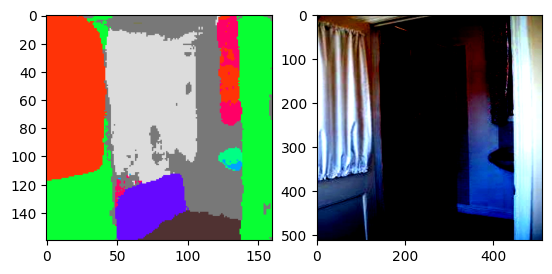

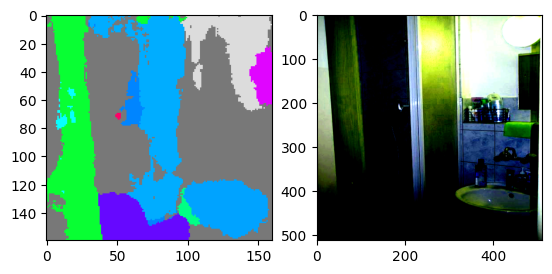

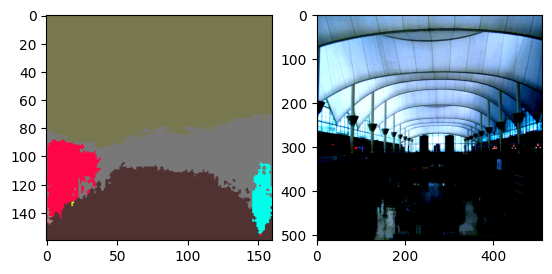

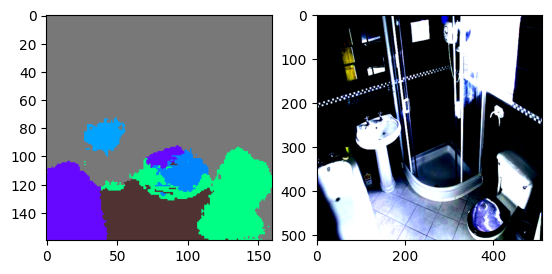

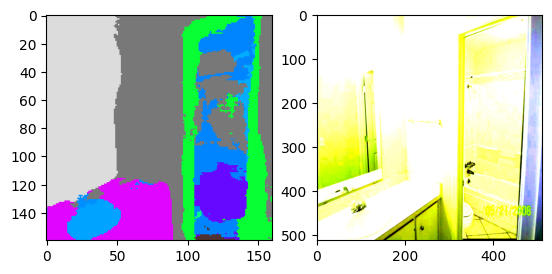

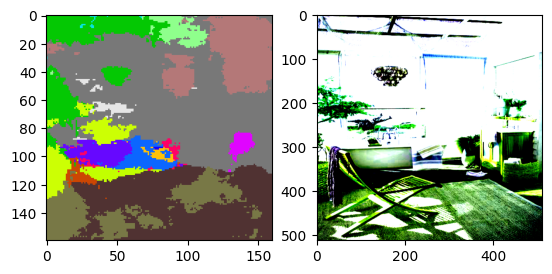

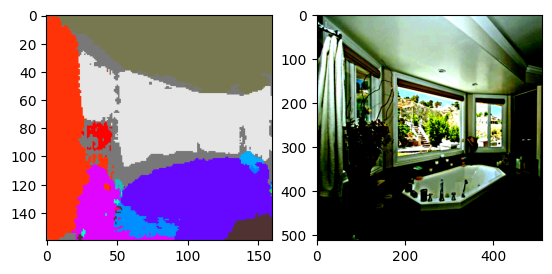

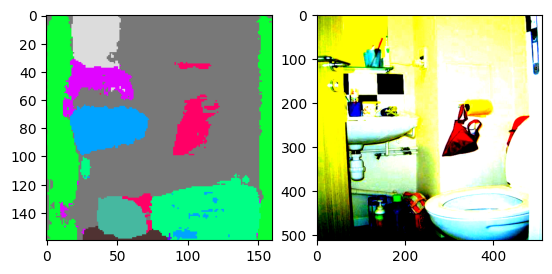

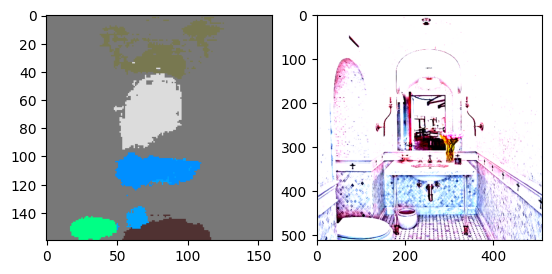

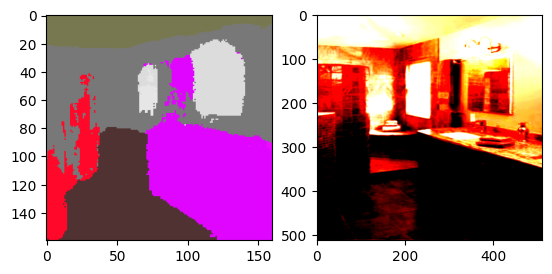

In [ ]:
from PIL import Image
for i in range(10):
    plt.subplot(1, 2, 1)
    out = inference(train_ds[i]['pixel_values'], 0)
    plt.imshow(out)
    #plt.show()
    plt.subplot(1, 2, 2)
    #im = Image.fromarray(train_ds[i]['pixel_values'].transpose(1,2,0).astype(np.uint8))
    #plt.imshow(im.resize((160,160)))
    plt.imshow(train_ds[i]['pixel_values'].transpose(1,2,0))
    plt.show()